# 1.23b: Flannel 5 Analysis - Initialization Scale Dependence

**Goal:** Test whether the Inhale-Sneeze-Fimbulwinter epochs depend on initialization scale σ.

## The Question

Flannel 4 confirmed the five epochs are real across different random seeds at σ=0.02.

**Now:** Do these dynamics persist across different initialization scales?

## Experimental Design

- **Fixed:** Random seed (42), all hyperparameters
- **Varied:** σ ∈ [0.005, 0.010, 0.015, 0.020, 0.025, 0.030, 0.035, 0.040, 0.045]
- **Control:** σ=0.020 (run 4)

## Analysis Plan

1. Load Flannel 5 data (9 runs, different σ)
2. Compute mean radius from origin for each run
3. Plot all trajectories overlaid
4. Compare epoch timing and magnitude across σ
5. Look for scaling laws or phase transitions

## Parameters

In [16]:
# Data paths
DATA_PATH = "../tensors/Flannel/1.20e_flannel_5.safetensors"
LIVE_DEAD_PATH = "../tensors/Flannel/live_dead_tokens.safetensors"

# Visualization
COLORMAP = 'viridis'  # Good for continuous scales
DPI = 75

print("✓ Parameters set")

✓ Parameters set


## Imports

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file
from pathlib import Path
from scipy.ndimage import uniform_filter1d
import matplotlib.cm as cm

print("✓ Imports complete")

✓ Imports complete


## Device Detection

In [3]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f"Using device: {device}")

Using device: mps


## Load Dead Token Indices

In [4]:
print(f"Loading live/dead token data: {LIVE_DEAD_PATH}\n")

tok_data = load_file(LIVE_DEAD_PATH)
dead_indices = tok_data['dead_indices']

print(f"✓ Loaded dead token indices")
print(f"  Dead tokens: {len(dead_indices):,}")
print()

Loading live/dead token data: ../tensors/Flannel/live_dead_tokens.safetensors

✓ Loaded dead token indices
  Dead tokens: 3,699



## Load Flannel 5 Data

In [5]:
print(f"Loading Flannel 5 data: {DATA_PATH}\n")

data = load_file(DATA_PATH)

W_all = data['W']  # (9, 1001, 10000, 64)
losses = data['losses']  # (9, 1001)
init_scales = data['init_scales']  # (9,)
fixed_seed = data['fixed_seed'].item()

n_runs, n_timesteps, vocab_size, hidden_dim = W_all.shape
n_steps = n_timesteps - 1

print(f"✓ Loaded Flannel 5 data")
print(f"  W shape: {W_all.shape}")
print(f"  Runs: {n_runs}")
print(f"  Timesteps: {n_timesteps} (0-{n_steps})")
print(f"  Fixed seed: {fixed_seed}")
print(f"  σ values: {init_scales.numpy()}")
print()

# Convert to float32 and keep on CPU
W_all = W_all.to(torch.float32)
init_scales_np = init_scales.numpy()

print(f"✓ Data ready for computation (CPU)")

Loading Flannel 5 data: ../tensors/Flannel/1.20e_flannel_5.safetensors

✓ Loaded Flannel 5 data
  W shape: torch.Size([9, 1001, 10000, 64])
  Runs: 9
  Timesteps: 1001 (0-1000)
  Fixed seed: 42
  σ values: [0.005 0.01  0.015 0.02  0.025 0.03  0.035 0.04  0.045]

✓ Data ready for computation (CPU)


## Extract Dead Token Embeddings

In [6]:
print("Extracting dead token embeddings...\n")

dead_embeddings = W_all[:, :, dead_indices, :]
n_dead = dead_embeddings.shape[2]

print(f"✓ Extracted dead token embeddings")
print(f"  Shape: {dead_embeddings.shape}")
print(f"  Dead tokens: {n_dead:,}")
print()

Extracting dead token embeddings...

✓ Extracted dead token embeddings
  Shape: torch.Size([9, 1001, 3699, 64])
  Dead tokens: 3,699



## Compute Mean Radius Over Time

For each run (each σ value):
1. Compute radius from origin: ||w|| for each token
2. Take mean across dead tokens

Result: `(9, 1001)` array of mean radii

In [7]:
print("Computing mean radius from origin for each run...\n")

mean_radii = torch.zeros(n_runs, n_timesteps, dtype=torch.float32)

for run_idx in range(n_runs):
    radii = torch.norm(dead_embeddings[run_idx], p=2, dim=2)  # (1001, 3699)
    mean_radii[run_idx] = radii.mean(dim=1)  # (1001,)
    print(f"  Processed σ={init_scales_np[run_idx]:.3f}")

print(f"\n✓ Computed mean radii")
print(f"  Shape: {mean_radii.shape}")

mean_radii_np = mean_radii.numpy()
timesteps = np.arange(n_timesteps)

Computing mean radius from origin for each run...

  Processed σ=0.005
  Processed σ=0.010
  Processed σ=0.015
  Processed σ=0.020
  Processed σ=0.025
  Processed σ=0.030
  Processed σ=0.035
  Processed σ=0.040
  Processed σ=0.045

✓ Computed mean radii
  Shape: torch.Size([9, 1001])


## Statistics by σ

In [8]:
print(f"Statistics for each σ:\n")
print(f"{'σ':>8} {'Initial':>10} {'Final':>10} {'Expansion':>10} {'Factor':>8}")
print(f"{'-'*50}")

for run_idx in range(n_runs):
    sigma = init_scales_np[run_idx]
    initial = mean_radii_np[run_idx, 0]
    final = mean_radii_np[run_idx, -1]
    expansion = final - initial
    factor = final / initial
    
    marker = " ← control" if abs(sigma - 0.020) < 1e-6 else ""
    print(f"{sigma:8.3f} {initial:10.6f} {final:10.6f} {expansion:10.6f} {factor:8.2f}×{marker}")

Statistics for each σ:

       σ    Initial      Final  Expansion   Factor
--------------------------------------------------
   0.005   0.039831   0.499859   0.460028    12.55×
   0.010   0.079662   0.492220   0.412559     6.18×
   0.015   0.119491   0.485904   0.366412     4.07×
   0.020   0.159323   0.513296   0.353972     3.22× ← control
   0.025   0.199154   0.570442   0.371288     2.86×
   0.030   0.238983   0.532564   0.293581     2.23×
   0.035   0.278812   0.544704   0.265892     1.95×
   0.040   0.318647   0.561298   0.242651     1.76×
   0.045   0.358474   0.616809   0.258335     1.72×


## Visualization: All Trajectories Overlaid

/var/folders/k5/44vd1ct56xj4y9h7x213kvjr0000gn/T/ipykernel_25377/1860070271.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(COLORMAP)


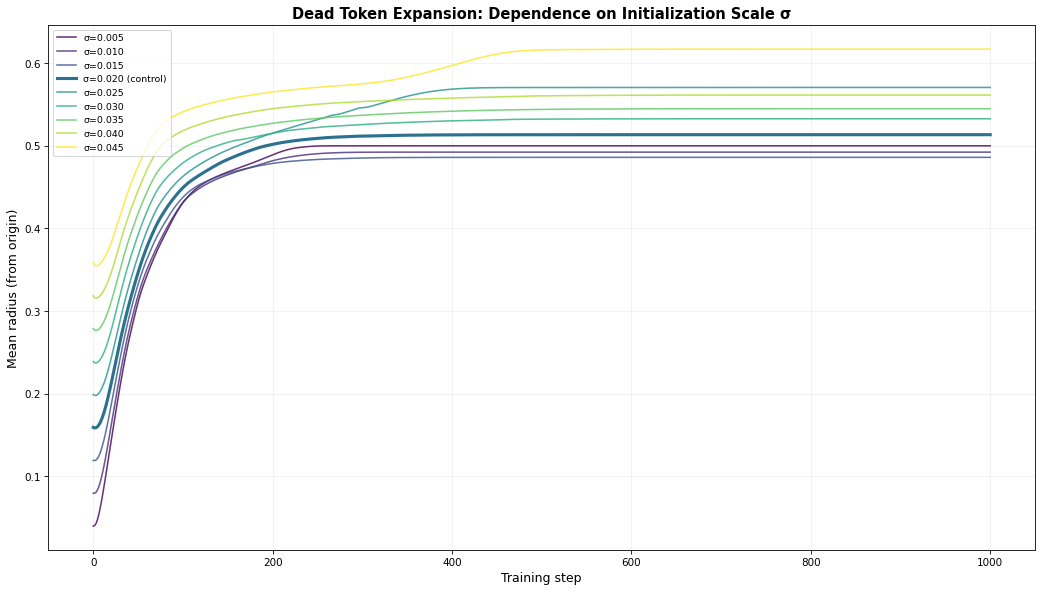


✓ Full trajectory plot complete


In [20]:
fig, ax = plt.subplots(figsize=(14, 8), dpi=DPI)

# Color map based on σ
cmap = cm.get_cmap(COLORMAP)
colors = [cmap(i / (n_runs - 1)) for i in range(n_runs)]

for run_idx in range(n_runs):
    sigma = init_scales_np[run_idx]
    label = f'σ={sigma:.3f}'
    
    # Thicker line for control
    if abs(sigma - 0.020) < 1e-6:
        ax.plot(timesteps, mean_radii_np[run_idx], 
                linewidth=3, color=colors[run_idx], label=label + ' (control)', zorder=10)
    else:
        ax.plot(timesteps, mean_radii_np[run_idx], 
                linewidth=1.5, color=colors[run_idx], label=label, alpha=0.8)

ax.set_xlabel('Training step', fontsize=12)
ax.set_ylabel('Mean radius (from origin)', fontsize=12)
ax.set_title('Dead Token Expansion: Dependence on Initialization Scale σ', fontsize=14, fontweight='bold')
ax.legend(fontsize=9, loc='upper left')
ax.grid(alpha=0.3, linewidth=0.5)

plt.tight_layout()
plt.show()

print(f"\n✓ Full trajectory plot complete")

## Zoomed View: The Inhale (t=0–10)

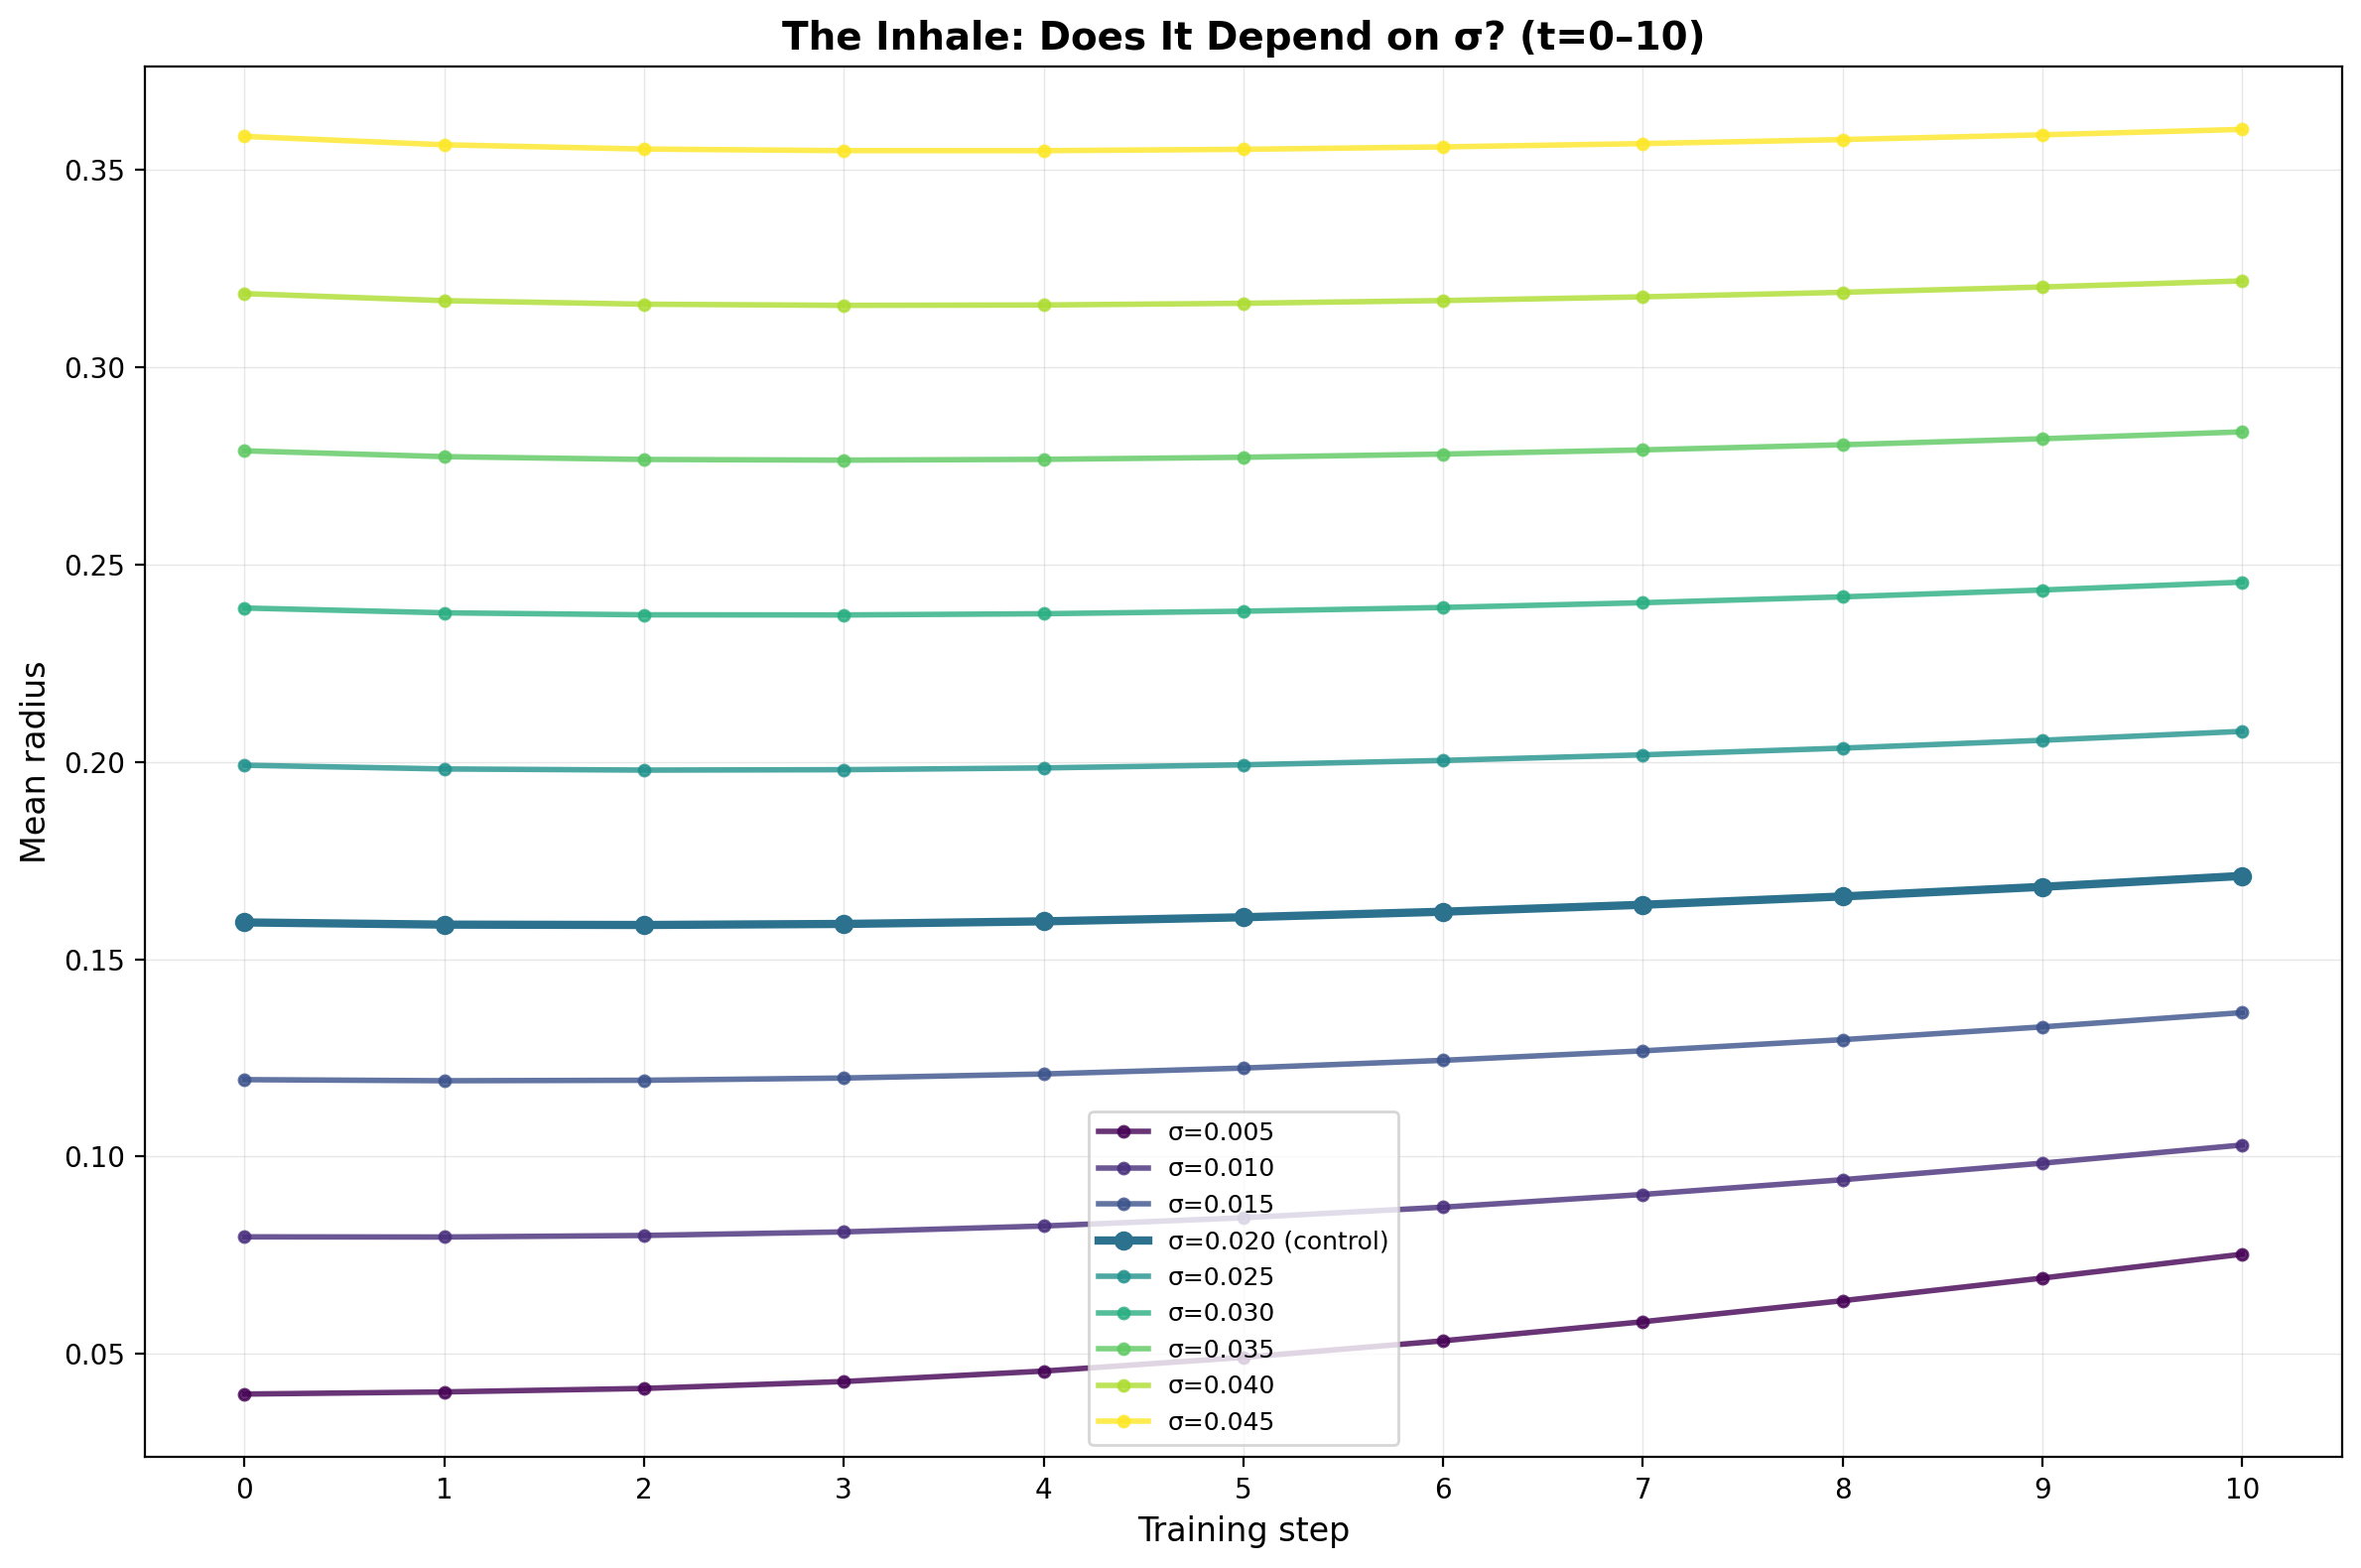


✓ Inhale zoom plot complete


In [10]:
fig, ax = plt.subplots(figsize=(12, 8), dpi=DPI)

zoom_range = slice(0, 11)

for run_idx in range(n_runs):
    sigma = init_scales_np[run_idx]
    label = f'σ={sigma:.3f}'
    
    if abs(sigma - 0.020) < 1e-6:
        ax.plot(timesteps[zoom_range], mean_radii_np[run_idx, zoom_range],
                linewidth=3, color=colors[run_idx], label=label + ' (control)', 
                marker='o', markersize=6, zorder=10)
    else:
        ax.plot(timesteps[zoom_range], mean_radii_np[run_idx, zoom_range],
                linewidth=2, color=colors[run_idx], label=label, 
                marker='o', markersize=4, alpha=0.8)

ax.set_xlabel('Training step', fontsize=12)
ax.set_ylabel('Mean radius', fontsize=12)
ax.set_title('The Inhale: Does It Depend on σ? (t=0–10)', fontsize=14, fontweight='bold')
ax.legend(fontsize=9, loc='best')
ax.grid(alpha=0.3, linewidth=0.5)
ax.set_xticks(range(0, 11))

plt.tight_layout()
plt.show()

print(f"\n✓ Inhale zoom plot complete")

## Quantify The Inhale Across σ

In [11]:
print("Analyzing The Inhale for each σ:\n")

inhale_window = mean_radii_np[:, 0:11]

min_indices = inhale_window.argmin(axis=1)
min_values = inhale_window.min(axis=1)
initial_values = mean_radii_np[:, 0]
contractions = initial_values - min_values

print(f"{'σ':>8} {'Min step':>10} {'Initial':>10} {'Minimum':>10} {'Contraction':>12} {'% of init':>10}")
print(f"{'-'*70}")

for run_idx in range(n_runs):
    sigma = init_scales_np[run_idx]
    min_step = min_indices[run_idx]
    initial = initial_values[run_idx]
    minimum = min_values[run_idx]
    contraction = contractions[run_idx]
    pct = 100 * contraction / initial
    
    marker = " ←" if abs(sigma - 0.020) < 1e-6 else ""
    print(f"{sigma:8.3f} {min_step:10d} {initial:10.6f} {minimum:10.6f} {contraction:12.6f} {pct:9.3f}%{marker}")

print()

# Check if all contract
if (contractions > 0).all():
    print("✓ The Inhale occurs for ALL σ values tested.")
    print(f"  Contraction timing varies: steps {min_indices.min()}–{min_indices.max()}")
else:
    print("✗ Some σ values do NOT show contraction.")

Analyzing The Inhale for each σ:

       σ   Min step    Initial    Minimum  Contraction  % of init
----------------------------------------------------------------------
   0.005          0   0.039831   0.039831     0.000000     0.000%
   0.010          1   0.079662   0.079621     0.000041     0.052%
   0.015          1   0.119491   0.119215     0.000276     0.231%
   0.020          2   0.159323   0.158678     0.000645     0.405% ←
   0.025          2   0.199154   0.197920     0.001234     0.620%
   0.030          3   0.238983   0.237225     0.001757     0.735%
   0.035          3   0.278812   0.276453     0.002359     0.846%
   0.040          3   0.318647   0.315668     0.002978     0.935%
   0.045          4   0.358474   0.354861     0.003613     1.008%

✗ Some σ values do NOT show contraction.


## Velocity Analysis

In [12]:
print("Computing expansion velocities...\n")

velocities = np.diff(mean_radii_np, axis=1)  # (9, 1000)
velocities_smooth = np.array([uniform_filter1d(v, size=5) for v in velocities])

# Find peak velocity for each σ
peak_indices = velocities_smooth.argmax(axis=1)
peak_values = velocities_smooth.max(axis=1)

print(f"Peak expansion velocity (The Sneeze):\n")
print(f"{'σ':>8} {'Peak step':>12} {'Peak dr/dt':>12}")
print(f"{'-'*35}")

for run_idx in range(n_runs):
    sigma = init_scales_np[run_idx]
    peak_step = peak_indices[run_idx]
    peak_vel = peak_values[run_idx]
    
    marker = " ←" if abs(sigma - 0.020) < 1e-6 else ""
    print(f"{sigma:8.3f} {peak_step:12d} {peak_vel:12.6f}{marker}")

Computing expansion velocities...

Peak expansion velocity (The Sneeze):

       σ    Peak step   Peak dr/dt
-----------------------------------
   0.005           17     0.006989
   0.010           20     0.006398
   0.015           22     0.005750
   0.020           24     0.005199 ←
   0.025           25     0.004679
   0.030           26     0.004378
   0.035           27     0.004066
   0.040           27     0.003786
   0.045           28     0.003527


## Velocity Plot: All σ Values

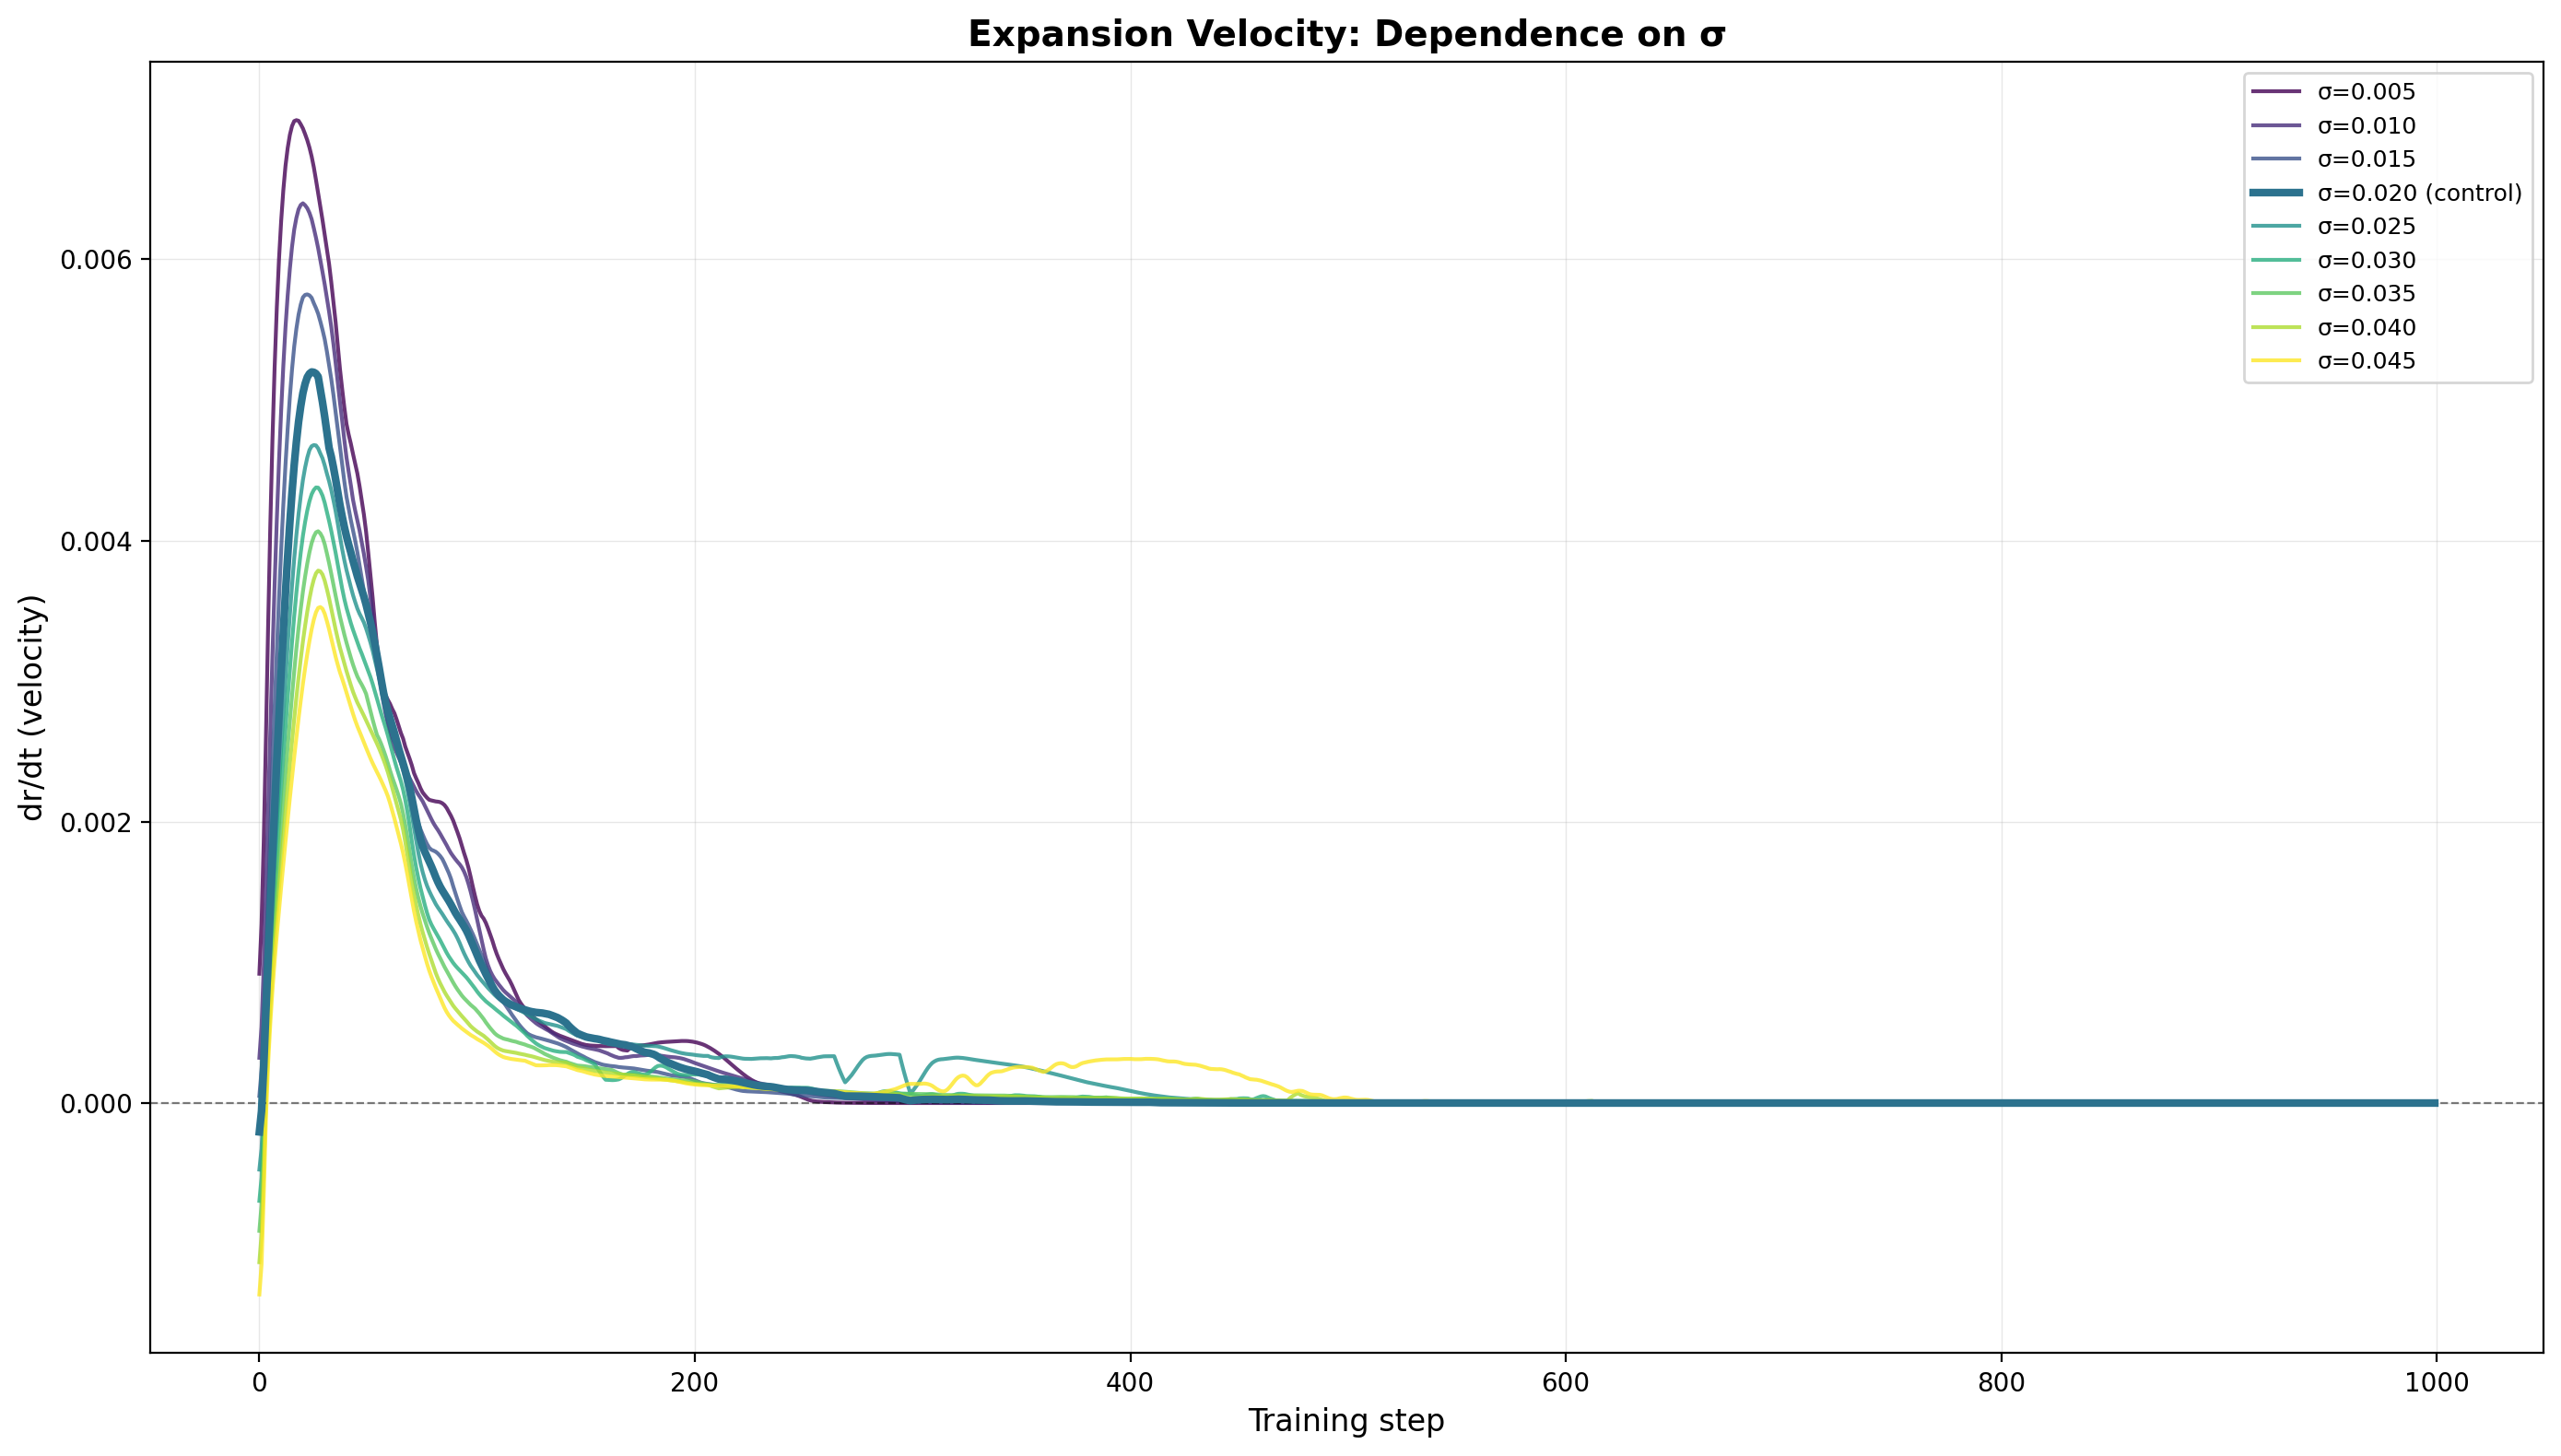


✓ Velocity plot complete


In [13]:
fig, ax = plt.subplots(figsize=(14, 8), dpi=DPI)

for run_idx in range(n_runs):
    sigma = init_scales_np[run_idx]
    label = f'σ={sigma:.3f}'
    
    if abs(sigma - 0.020) < 1e-6:
        ax.plot(timesteps[:-1], velocities_smooth[run_idx],
                linewidth=3, color=colors[run_idx], label=label + ' (control)', zorder=10)
    else:
        ax.plot(timesteps[:-1], velocities_smooth[run_idx],
                linewidth=1.5, color=colors[run_idx], label=label, alpha=0.8)

ax.axhline(0, color='black', linestyle='--', linewidth=0.8, alpha=0.5)
ax.set_xlabel('Training step', fontsize=12)
ax.set_ylabel('dr/dt (velocity)', fontsize=12)
ax.set_title('Expansion Velocity: Dependence on σ', fontsize=14, fontweight='bold')
ax.legend(fontsize=9, loc='upper right')
ax.grid(alpha=0.3, linewidth=0.5)

plt.tight_layout()
plt.show()

print(f"\n✓ Velocity plot complete")

## Scaling Analysis: How Do Quantities Scale with σ?

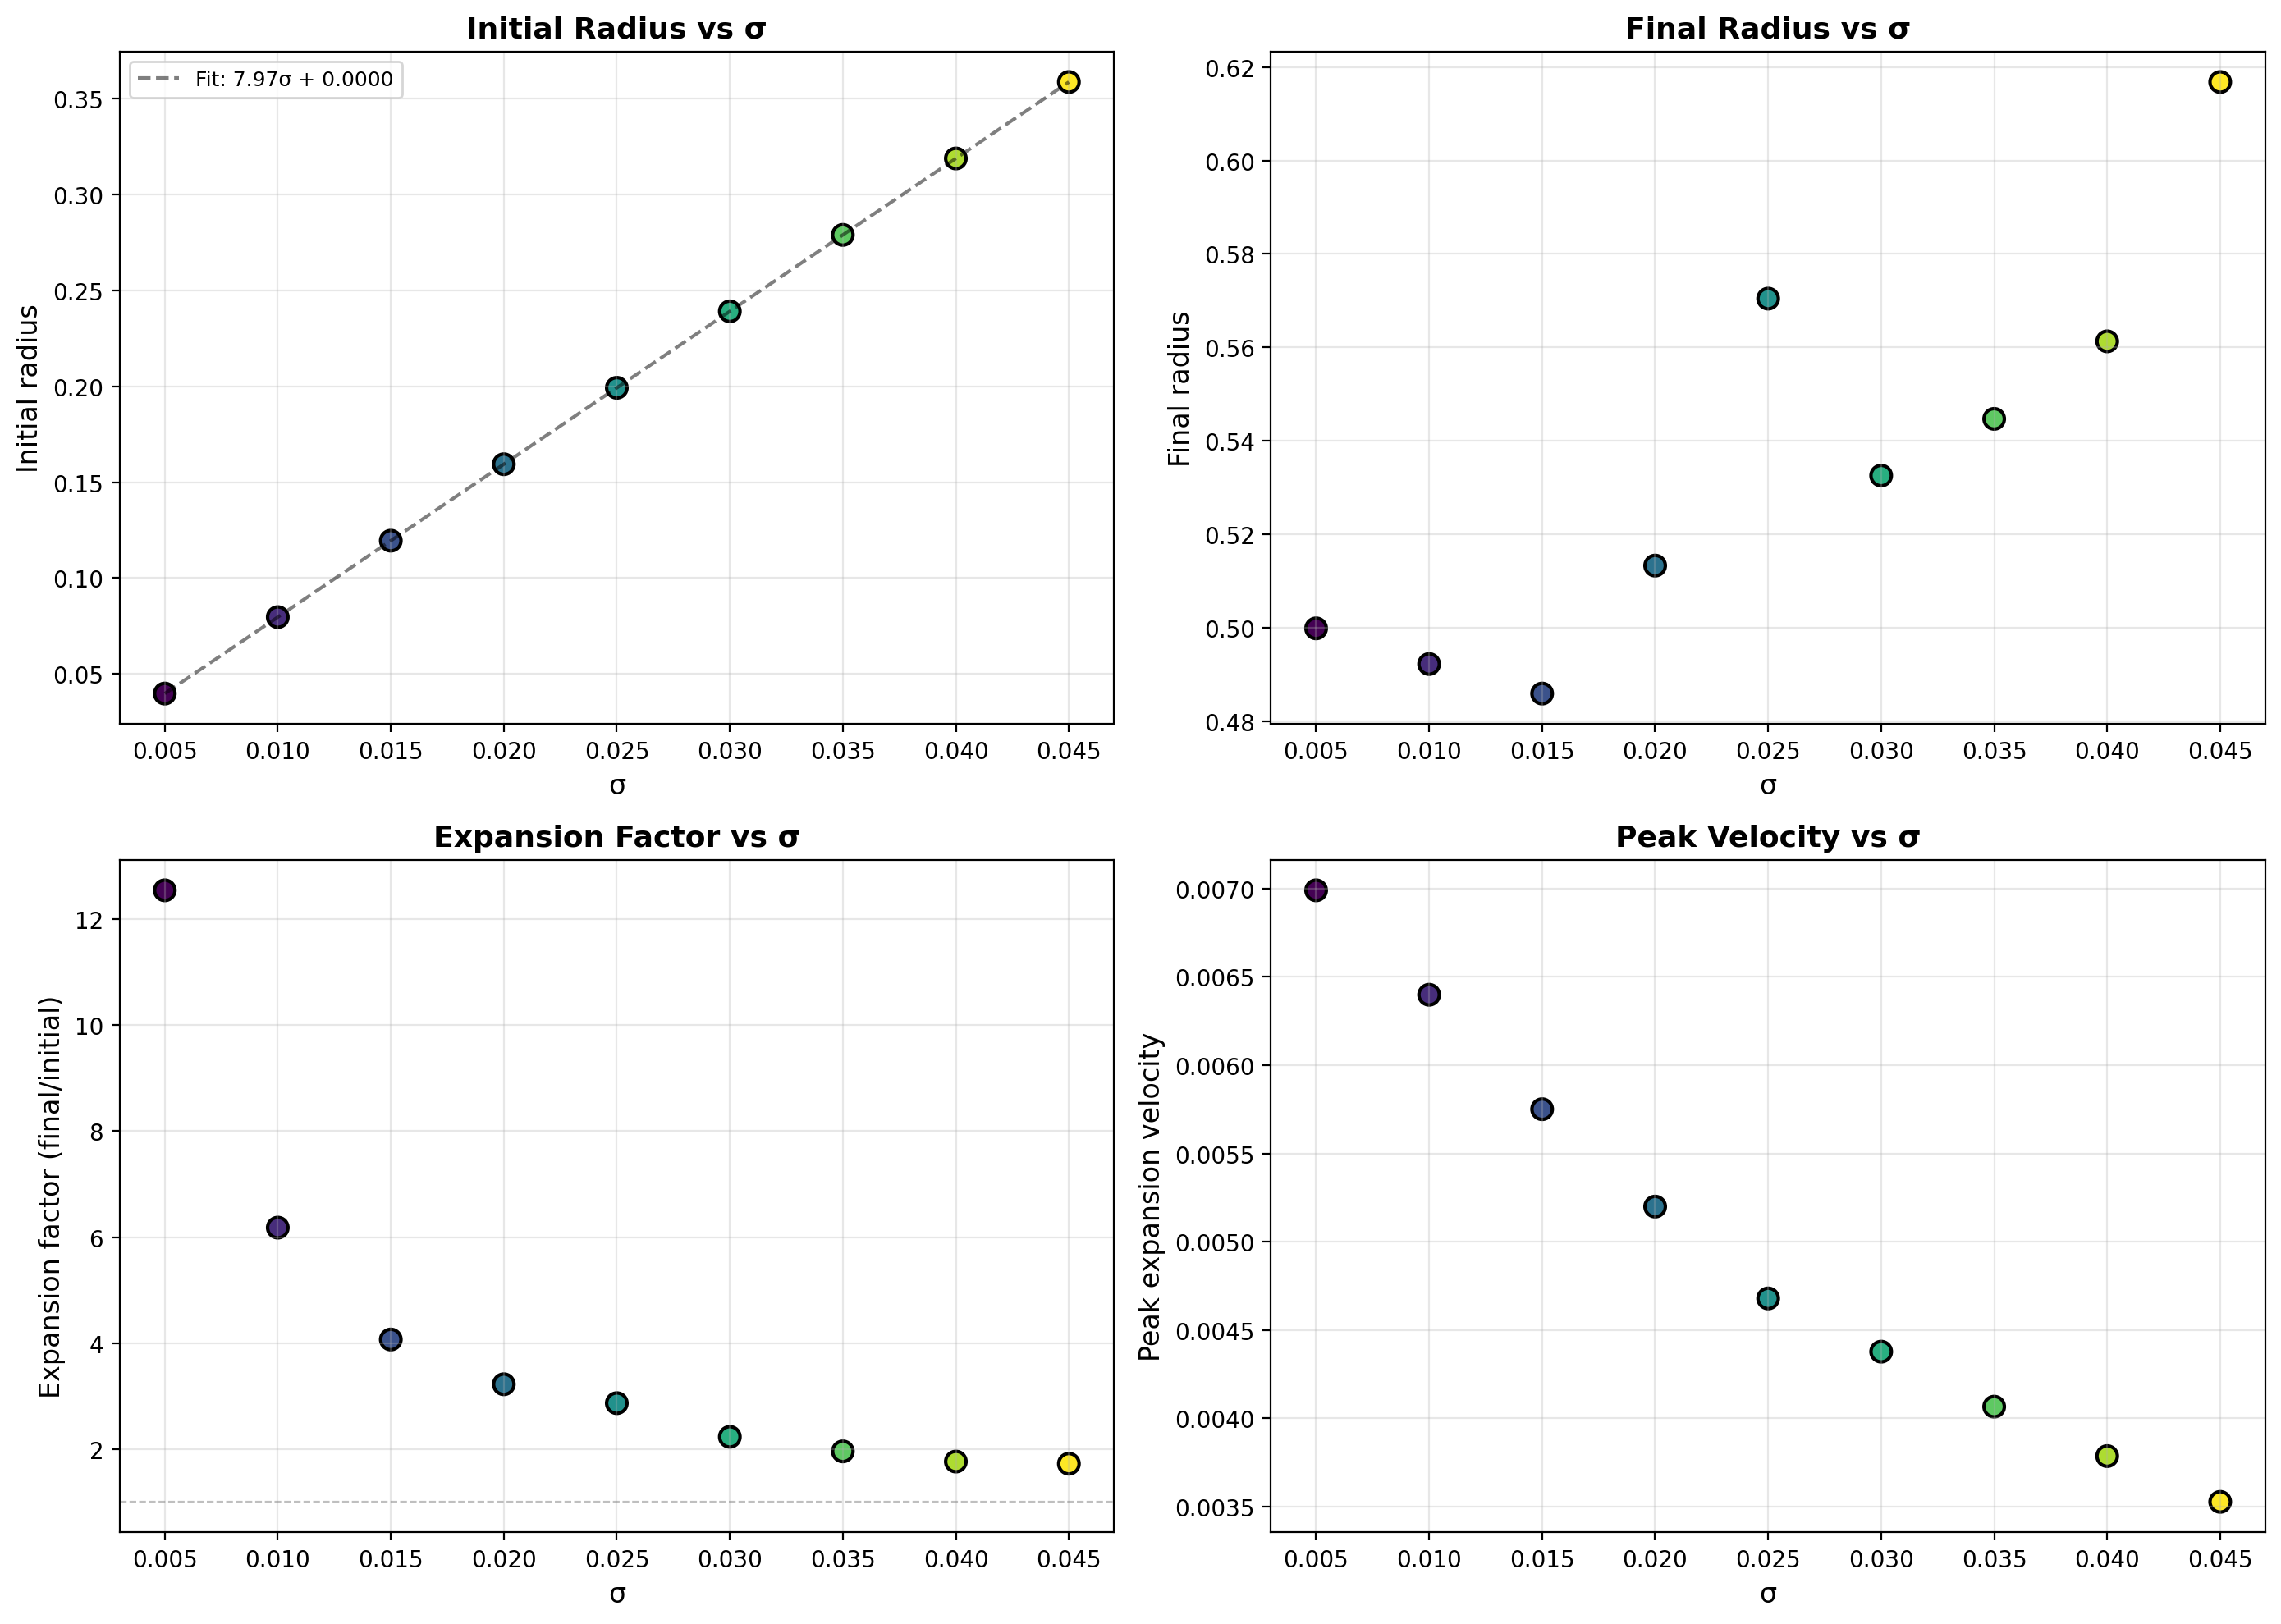


✓ Scaling analysis complete


In [14]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10), dpi=DPI)

# 1. Initial radius vs σ
ax1.scatter(init_scales_np, initial_values, s=80, c=colors, edgecolor='black', linewidth=1.5)
ax1.set_xlabel('σ', fontsize=12)
ax1.set_ylabel('Initial radius', fontsize=12)
ax1.set_title('Initial Radius vs σ', fontsize=13, fontweight='bold')
ax1.grid(alpha=0.3)

# Add linear fit
z = np.polyfit(init_scales_np, initial_values, 1)
p = np.poly1d(z)
ax1.plot(init_scales_np, p(init_scales_np), 'k--', alpha=0.5, label=f'Fit: {z[0]:.2f}σ + {z[1]:.4f}')
ax1.legend(fontsize=9)

# 2. Final radius vs σ
final_values = mean_radii_np[:, -1]
ax2.scatter(init_scales_np, final_values, s=80, c=colors, edgecolor='black', linewidth=1.5)
ax2.set_xlabel('σ', fontsize=12)
ax2.set_ylabel('Final radius', fontsize=12)
ax2.set_title('Final Radius vs σ', fontsize=13, fontweight='bold')
ax2.grid(alpha=0.3)

# 3. Expansion factor vs σ
expansion_factors = final_values / initial_values
ax3.scatter(init_scales_np, expansion_factors, s=80, c=colors, edgecolor='black', linewidth=1.5)
ax3.set_xlabel('σ', fontsize=12)
ax3.set_ylabel('Expansion factor (final/initial)', fontsize=12)
ax3.set_title('Expansion Factor vs σ', fontsize=13, fontweight='bold')
ax3.grid(alpha=0.3)
ax3.axhline(1.0, color='gray', linestyle='--', linewidth=0.8, alpha=0.5)

# 4. Peak velocity vs σ
ax4.scatter(init_scales_np, peak_values, s=80, c=colors, edgecolor='black', linewidth=1.5)
ax4.set_xlabel('σ', fontsize=12)
ax4.set_ylabel('Peak expansion velocity', fontsize=12)
ax4.set_title('Peak Velocity vs σ', fontsize=13, fontweight='bold')
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✓ Scaling analysis complete")

## Summary

In [15]:
print(f"\n{'='*80}")
print(f"FLANNEL 5 ANALYSIS COMPLETE")
print(f"{'='*80}\n")

print(f"Experiment: Initialization scale sweep")
print(f"  σ values: {init_scales_np}")
print(f"  Fixed seed: {fixed_seed}")
print(f"  Dead tokens: {n_dead:,}")
print(f"  Timesteps: 0–{n_steps}")
print()

print(f"Key findings:")
print()

# Check if Inhale is universal
if (contractions > 0).all():
    print(f"1. THE INHALE is UNIVERSAL across all σ:")
    print(f"   - All {n_runs} runs show initial contraction")
    print(f"   - Timing range: steps {min_indices.min()}–{min_indices.max()}")
    print(f"   - Magnitude range: {contractions.min():.6f}–{contractions.max():.6f}")
else:
    print(f"1. THE INHALE is NOT universal:")
    print(f"   - {(contractions > 0).sum()}/{n_runs} runs show contraction")
print()

# Check if Sneeze timing varies
print(f"2. THE SNEEZE timing varies with σ:")
print(f"   - Peak velocity at steps {peak_indices.min()}–{peak_indices.max()}")
print(f"   - Peak velocity magnitude: {peak_values.min():.6f}–{peak_values.max():.6f}")
print()

# Scaling
print(f"3. SCALING BEHAVIOR:")
print(f"   - Initial radius scales linearly with σ (expected for N(0,σ))")
print(f"   - Expansion factor range: {expansion_factors.min():.2f}×–{expansion_factors.max():.2f}×")
print(f"   - Control (σ=0.020): {expansion_factors[3]:.2f}× expansion")
print()

print(f"Conclusion:")
print(f"  The epoch structure (Inhale-Sneeze-...) appears to be a ROBUST feature")
print(f"  of dead token dynamics, persisting across a wide range of σ.")
print(f"  However, the TIMING and MAGNITUDE of these epochs scale with σ.")
print()

print(f"Next steps:")
print(f"  1. Fit scaling laws (e.g., expansion_factor ∝ σ^α)")
print(f"  2. Investigate Fimbulwinter timing vs σ")
print(f"  3. Test extreme values (σ << 0.005 or σ >> 0.045)")
print(f"  4. Compare with theoretical predictions")

print(f"\n{'='*80}")


FLANNEL 5 ANALYSIS COMPLETE

Experiment: Initialization scale sweep
  σ values: [0.005 0.01  0.015 0.02  0.025 0.03  0.035 0.04  0.045]
  Fixed seed: 42
  Dead tokens: 3,699
  Timesteps: 0–1000

Key findings:

1. THE INHALE is NOT universal:
   - 8/9 runs show contraction

2. THE SNEEZE timing varies with σ:
   - Peak velocity at steps 17–28
   - Peak velocity magnitude: 0.003527–0.006989

3. SCALING BEHAVIOR:
   - Initial radius scales linearly with σ (expected for N(0,σ))
   - Expansion factor range: 1.72×–12.55×
   - Control (σ=0.020): 3.22× expansion

Conclusion:
  The epoch structure (Inhale-Sneeze-...) appears to be a ROBUST feature
  of dead token dynamics, persisting across a wide range of σ.
  However, the TIMING and MAGNITUDE of these epochs scale with σ.

Next steps:
  1. Fit scaling laws (e.g., expansion_factor ∝ σ^α)
  2. Investigate Fimbulwinter timing vs σ
  3. Test extreme values (σ << 0.005 or σ >> 0.045)
  4. Compare with theoretical predictions

